In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from torch.autograd import Variable
train_x = Variable(torch.linspace(0, 1, 15))
train_y = Variable(torch.sign(torch.cos(train_x.data * (2 * math.pi))))

In [3]:
from gpytorch.kernels import RBFKernel
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood, BernoulliLikelihood
from gpytorch import ObservationModel
from gpytorch.random_variables import GaussianRandomVariable
from gpytorch.parameters import MLEParameterGroup
from torch.nn import Parameter

In [4]:
class GPClassificationModel(gpytorch.ObservationModel):
    def __init__(self):
        super(GPClassificationModel,self).__init__(BernoulliLikelihood())
        self.mean_module = ConstantMean()
        self.covar_module = RBFKernel()
        self.params = MLEParameterGroup(
            log_lengthscale=Parameter(torch.Tensor([math.log(0.1)])),
            log_outputscale=Parameter(torch.Tensor([-1])),
        )
    
    def forward(self,x):
        mean_x = self.mean_module(x, constant=Variable(torch.Tensor([0])))
        covar_x = self.covar_module(x, log_lengthscale=self.params.log_lengthscale)
        covar_x = covar_x.mul(self.params.log_outputscale.exp().expand_as(covar_x))
        latent_pred = GaussianRandomVariable(mean_x, covar_x)
        return latent_pred

prior_observation_model = GPClassificationModel()

In [5]:
def plot_model_and_predictions(observation_model):
    f, observed_ax = plt.subplots(1, 1, figsize=(4, 3))
    test_x = Variable(torch.linspace(0, 1, 51))
    observed_pred = observation_model(test_x)

    def ax_plot(ax, rand_var, title):
        pred_probs = rand_var.mean()
        pred_labels = rand_var.mean().ge(0.5).float().mul(2).sub(1)
        ax.plot(train_x.data.numpy(), train_y.data.numpy(), 'k*')
        ax.plot(test_x.data.numpy(), pred_labels.data.numpy(), 'b')
        ax.set_ylim([-3, 3])
        ax.legend(['Observed Data', 'Mean'])
        ax.set_title(title)
    
    ax_plot(observed_ax, observed_pred, 'Observed Values (Likelihood)')
    
    return f

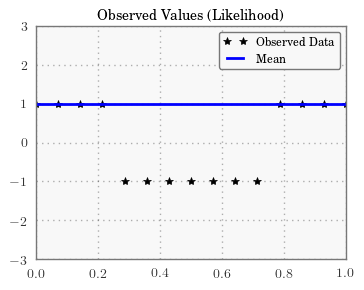

In [6]:
f = plot_model_and_predictions(prior_observation_model)

In [9]:
from gpytorch.inference import Inference
infer = Inference(prior_observation_model)
posterior_observation_model = infer.run(train_x, train_y, max_inference_steps=20)

0 -236475.671875
1 -31.4688072205
2 -25.6228637695
3 -21.6823501587
4 -22.6328334808
5 -19.9356155396
6 -20.2158145905
7 -16.3680763245
8 -17.0179977417
9 -17.2581748962
10 -14.0514574051
11 -13.9381484985
12 -19.2147445679
13 -16.0470123291
14 -24.139131546
15 -16.7104721069
16 -16.0212898254
17 -16.0530090332
18 -21.934343338
19 -15.6364545822


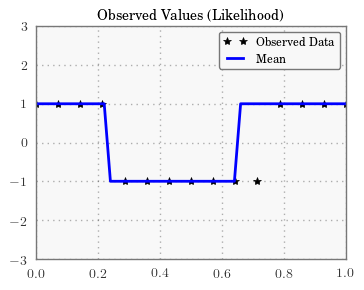

In [10]:
f = plot_model_and_predictions(posterior_observation_model)